# Propensity Score Estimation Methods
---
## The four steps of causal inference

### I. Model a causal problem
- Create a causal DAG for your system of interest.

### II. Identify a target estimand under the model
- Identify the causal estimand under the assumptions of the causal DAG.

### III. Estimate the causal effect based on the identified estimand
- Estimate the estimand using any kind of Stats/ML model e.g. linear regression, random forest etc.

### IV. Refute the obtain estimate
- Peform refutations on the estimate to test its robustness 

In [1]:
import numpy as np
import pandas as pd
import patsy as ps
import statsmodels
import dowhy
from dowhy import CausalModel
import econml
from IPython.display import Image, display
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt

random_state=42

# Avoid printing dataconversion warnings from sklearn
# Config dict to set the logging level
import logging.config
import warnings
warnings.filterwarnings('ignore')
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}
logging.config.dictConfig(DEFAULT_LOGGING)

# Import custom dowhy helper functions module
cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')
sys.path.append(SCRIPT_DIR)
import dowhy_helpers as dwh

In [3]:
# I/O Stuff
DATA_FILENAME = "csdh_clean.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)
# Mapping bedrest to categorical variable
csdh['bedrest'] = csdh['bedrest'].map({'None':0, '<12hrs':1, '12-24hrs':2, '25-48hrs':3, '>48hrs':4})
# Drop NAs for DAG containing burrhole_num variable
csdh_burr = csdh.drop(csdh[csdh['burrhole_num'].isna()].index, axis=0)
csdh.to_csv('csdh_final.csv')
csdh_burr.to_csv('csdh_burr.csv')

---
## 0. Naïve Estimation (no causal inference)

In [4]:
# Mask treatment variable as bool 
# DoWhy is still in development and does not support int treatments for propensity_score_weighting
csdh['drain'] = csdh['drain'].astype(bool)

# Dataset without dropping burrhole_num NA patients
naive_est = dwh.naive_estimate(df=csdh, treatment='drain', outcome='recurrence', treatment_type='int')
print(f"Without adjusting for any confounding, the naive causal estimate is computed as {naive_est}")

Without adjusting for any confounding, the naive causal estimate is computed as -0.09356128931064231


In [5]:
csdh_burr['drain'] = csdh_burr['drain'].astype(bool)

# Dataset after dropping patients with missing burrhole_num
naive_est_burr = dwh.naive_estimate(df=csdh_burr, treatment='drain', outcome='recurrence', treatment_type='int')
print(f"Without adjusting for any confounding, the naive causal estimate is computed as {naive_est_burr}")

Without adjusting for any confounding, the naive causal estimate is computed as -0.08374644024891888


---
## I. Model a causal problem
* Create a causal model from the data and given graph.

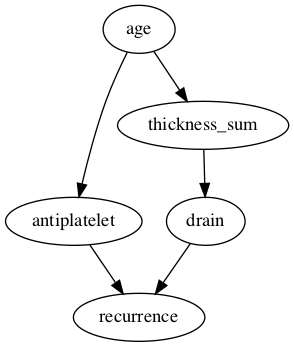

In [6]:
min_model = CausalModel(data=csdh, 
                        treatment='drain', 
                        outcome='recurrence', 
                        graph='../causal_graphs/min_dag.dot'.replace("\n", " "))
min_model.view_model()
display(Image(filename="causal_model.png"))

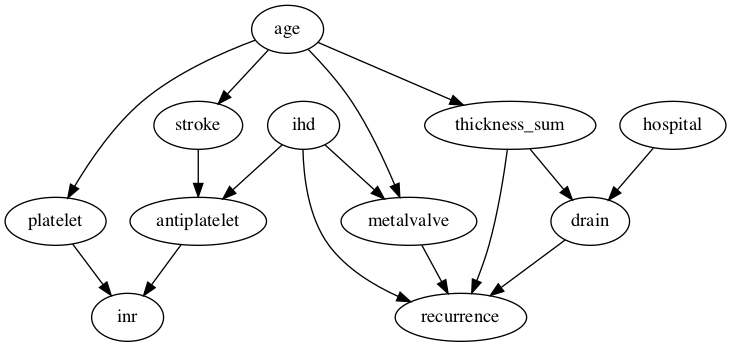

In [7]:
data_model = CausalModel(data=csdh, 
                         treatment='drain', 
                         outcome='recurrence', 
                         graph='../causal_graphs/small_data_dag.dot'.replace("\n", " "))
data_model.view_model()
display(Image(filename="causal_model.png"))

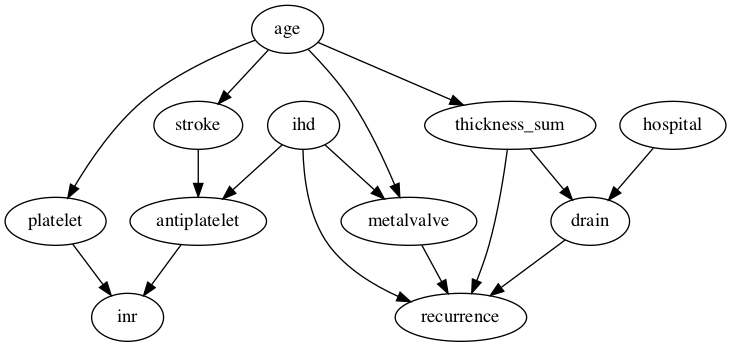

In [8]:
doc_model = CausalModel(data=csdh_burr, 
                         treatment='drain', 
                         outcome='recurrence', 
                         graph='../causal_graphs/doctor_dag.dot'.replace("\n", " "))
data_model.view_model()
display(Image(filename="causal_model.png"))

---
## II. Identify a target estimand under the model

In [9]:
min_estimand = min_model.identify_effect(proceed_when_unidentifiable=True)
data_estimand = data_model.identify_effect(proceed_when_unidentifiable=True)
doc_estimand = doc_model.identify_effect(proceed_when_unidentifiable=True)

---
## III. Propensity Score Weighting Estimator
### Inverse probability weighting (IPW) has been chosen


In [9]:
# Propensity score matching
min_weight_est = min_model.estimate_effect(min_estimand,
                                           method_name="backdoor.propensity_score_weighting",
                                           control_value=False,
                                           treatment_value=True,
                                           test_significance=True,
                                           confidence_intervals=True,
                                           method_params={"weighting_scheme":"ips_weight"})

In [10]:
data_weight_est = data_model.estimate_effect(data_estimand,
                                             method_name="backdoor.propensity_score_weighting",
                                             control_value=False,
                                             treatment_value=True,
                                             test_significance=True,
                                             confidence_intervals=True,
                                             method_params={"weighting_scheme":"ips_weight"})

In [11]:
doc_weight_est = doc_model.estimate_effect(doc_estimand,
                                           method_name="backdoor.propensity_score_weighting",
                                           control_value=False,
                                           treatment_value=True,
                                           test_significance=True,
                                           confidence_intervals=True,
                                           method_params={"weighting_scheme":"ips_weight"})

In [12]:
print(min_weight_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                            
────────(Expectation(recurrence|age,antiplatelet,thickness_sum))
d[drain]                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,age,antiplatelet,thickness_sum,U) = P(recurrence|drain,age,antiplatelet,thickness_sum)

## Realized estimand
b: recurrence~drain+age+antiplatelet+thickness_sum
Target units: ate

## Estimate
Mean value: -0.1110558892557952
p-value: [0, 0.001]
95.0% confidence interval: (-0.17157470408502895, -0.04960315178767197)



In [13]:
print(data_weight_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|inr,age,stroke,metalvalve,thickness_sum,ihd,pl
d[drain]                                                                      

                     
atelet,antiplatelet))
                     
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,inr,age,stroke,metalvalve,thickness_sum,ihd,platelet,antiplatelet,U) = P(recurrence|drain,inr,age,stroke,metalvalve,thickness_sum,ihd,platelet,antiplatelet)

## Realized estimand
b: recurrence~drain+inr+age+stroke+metalvalve+thickness_sum+ihd+platelet+antiplatelet
Target units: ate

## Estimate
Mean value: -0.11129472717428104
p-value: [0, 0.001]
95.0% confidence interval: (-0.16842936526685542, -0.04724328758392725)



In [14]:
print(doc_weight_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|density,bedrest,age,burrhole_num,stroke,metalv
d[drain]                                                                      

                                                                        
alve,warfarin,membranes,hospital,thickness_sum,ihd,optype,antiplatelet))
                                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,density,bedrest,age,burrhole_num,stroke,metalvalve,warfarin,membranes,hospital,thickness_sum,ihd,optype,antiplatelet,U) = P(recurrence|drain,density,bedrest,age,burrhole_num,stroke,metalvalve,warfarin,membranes,hospital,thickness_sum,ihd,optype,antiplatelet)

## Realized estimand
b: recurrence~drain+den

In [15]:
# mp model
dwh.print_estimate_comparison(naive_est, min_weight_est, 'IPW')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
IPW causal estimate is -0.1110558892557952
Percentage change from naive_est: 18.699%
----------------------------------------------


In [16]:
# data model
dwh.print_estimate_comparison(naive_est, data_weight_est, 'IPW')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
IPW causal estimate is -0.11129472717428104
Percentage change from naive_est: 18.954%
----------------------------------------------


In [17]:
# small data model
dwh.print_estimate_comparison(naive_est_burr, doc_weight_est, 'IPW')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.08374644024891888
IPW causal estimate is -0.08886204158748431
Percentage change from naive_est: 6.108%
----------------------------------------------


---
### III. IPW Interpreters

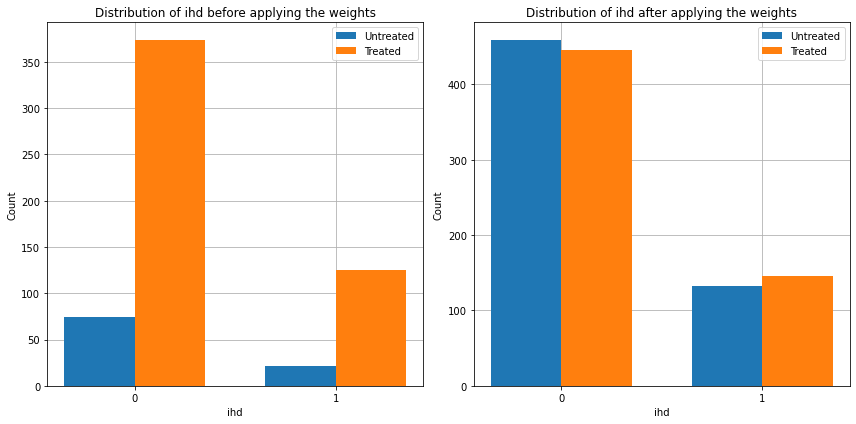

In [18]:
dwh.plot_ipw_interpreter(doc_weight_est, 'ihd')

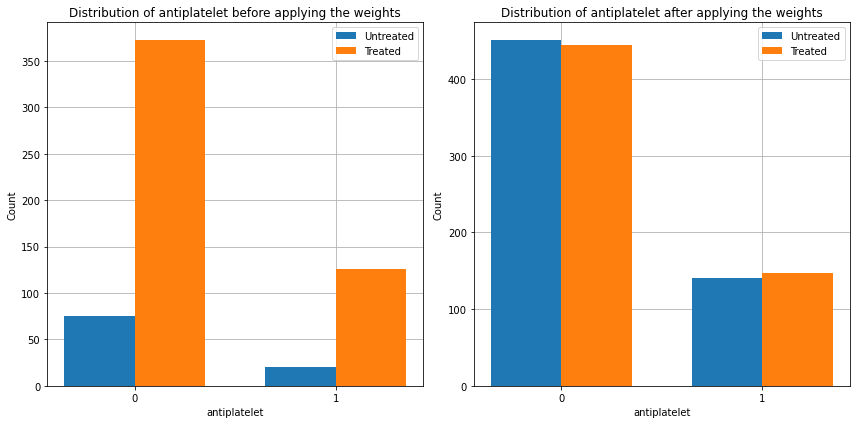

In [19]:
dwh.plot_ipw_interpreter(doc_weight_est, 'antiplatelet')

---
## IV. Refute the obtained estimate

1. **Add Random Common Cause:** Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [20]:
min_ran_weight_refuter = min_model.refute_estimate(min_estimand, min_weight_est, 
                                                   num_simulations=10,
                                                   random_state=random_state,
                                                   method_name='random_common_cause')

In [21]:
data_ran_weight_refuter = data_model.refute_estimate(data_estimand, data_weight_est, 
                                                     num_simulations=10,
                                                     random_state=random_state,
                                                     method_name='random_common_cause')

In [22]:
doc_ran_weight_refuter = doc_model.refute_estimate(doc_estimand, 
                                                   doc_weight_est,
                                                   num_simulations=10,
                                                   random_state=random_state,
                                                   method_name='random_common_cause')

In [23]:
# Robust if: new estimate is similar to estimated effect
print(min_ran_weight_refuter)
print(data_ran_weight_refuter)
print(doc_ran_weight_refuter)

Refute: Add a Random Common Cause
Estimated effect:-0.1110558892557952
New effect:-0.11143818861182875

Refute: Add a Random Common Cause
Estimated effect:-0.11129472717428104
New effect:-0.1079056157753879

Refute: Add a Random Common Cause
Estimated effect:-0.08886204158748431
New effect:-0.08627837972882302



2. **Placebo Treatment:** What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)


- Note that the placebo type is 'permute' meaning the rows of the treatment variable have been randomly permuted giving the effect of a placebo treatment.

In [24]:
min_placebo_weight_refuter = min_model.refute_estimate(min_estimand, min_weight_est,
                                                       placebo_type='permute',
                                                       num_similations=10,
                                                       method_name='placebo_treatment_refuter')

In [25]:
data_placebo_weight_refuter = data_model.refute_estimate(data_estimand, data_weight_est,
                                                         placebo_type='permute',
                                                         num_similations=10,
                                                         method_name='placebo_treatment_refuter')

In [26]:
doc_placebo_weight_refuter = doc_model.refute_estimate(doc_estimand, doc_weight_est,
                                                       placebo_type='permute',
                                                       num_similations=10,
                                                       method_name='placebo_treatment_refuter')

In [27]:
print(min_placebo_weight_refuter)
print(data_placebo_weight_refuter)
print(doc_placebo_weight_refuter)

Refute: Use a Placebo Treatment
Estimated effect:-0.1110558892557952
New effect:-0.002375026784069478
p value:0.43000000000000005

Refute: Use a Placebo Treatment
Estimated effect:-0.11129472717428104
New effect:-0.0010109951547916903
p value:0.48

Refute: Use a Placebo Treatment
Estimated effect:-0.08886204158748431
New effect:0.0013565819065053805
p value:0.47



3. **Dummy Outcome:** What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)


- The result shows that when using a dummy outcome, the **treatment does not lead to the outcome**. The estimated effect is hence a value that tends to zero, which matches our expectation. This shows that if we replace the outcome by randomly generated data, the **estimator correctly predicts that the influence if treatment is zero**.

In [28]:
min_dummy_weight_refuter = min_model.refute_estimate(min_estimand, min_weight_est, 
                                                     num_simulations=10, 
                                                     random_state=random_state,
                                                     method_name='dummy_outcome_refuter')

In [29]:
data_dummy_weight_refuter = data_model.refute_estimate(data_estimand, data_weight_est, 
                                                       num_simulations=10, 
                                                       random_state=random_state,
                                                       method_name='dummy_outcome_refuter')

In [30]:
doc_dummy_weight_refuter = doc_model.refute_estimate(doc_estimand, 
                                                     doc_weight_est, 
                                                     num_simulations=10,
                                                     random_state=random_state,
                                                     method_name='dummy_outcome_refuter')

In [31]:
print(min_dummy_weight_refuter[0])
print(data_dummy_weight_refuter[0])
print(doc_dummy_weight_refuter[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.03574457694674883
p value:0.39636192203309084

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.0202816830761897
p value:0.38435342599138234

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.05968735045750771
p value:0.2538755368744288



4. **Data Subsets Validation:** Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

In [32]:
min_subset_weight_refuter = min_model.refute_estimate(min_estimand, min_weight_est, 
                                                      num_simulations=10, 
                                                      subset_fraction=0.75, 
                                                      random_state=random_state,
                                                      method_name='data_subset_refuter')

In [33]:
data_subset_weight_refuter = data_model.refute_estimate(data_estimand, data_weight_est, 
                                                        num_simulations=10, 
                                                        subset_fraction=0.75, 
                                                        random_state=random_state,
                                                        method_name='data_subset_refuter')

In [34]:
doc_subset_weight_refuter = doc_model.refute_estimate(doc_estimand, 
                                                      doc_weight_est, 
                                                      num_simulations=10, 
                                                      subset_fraction=0.75, 
                                                      random_state=random_state,
                                                      method_name='data_subset_refuter')

In [35]:
print(min_subset_weight_refuter)
print(data_subset_weight_refuter)
print(doc_subset_weight_refuter)

Refute: Use a subset of data
Estimated effect:-0.1110558892557952
New effect:-0.09979805687805907
p value:0.0

Refute: Use a subset of data
Estimated effect:-0.11129472717428104
New effect:-0.10270321404665746
p value:0.0

Refute: Use a subset of data
Estimated effect:-0.08886204158748431
New effect:-0.06710073548992367
p value:0.0



5. **Bootstrap Validation:** Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

In [36]:
min_bootstrap_weight_refuter = min_model.refute_estimate(min_estimand, min_weight_est, 
                                                        num_simulations=10, 
                                                        random_state=random_state,
                                                        method_name='bootstrap_refuter')

In [37]:
data_bootstrap_weight_refuter = data_model.refute_estimate(data_estimand, data_weight_est, 
                                                           num_simulations=10, 
                                                           random_state=random_state,
                                                           method_name='bootstrap_refuter')

In [38]:
doc_bootstrap_weight_refuter = doc_model.refute_estimate(doc_estimand, doc_weight_est, 
                                                         num_simulations=10, 
                                                         random_state=random_state,
                                                         method_name='bootstrap_refuter')

In [39]:
print(min_bootstrap_weight_refuter)
print(data_bootstrap_weight_refuter)
print(doc_bootstrap_weight_refuter)

Refute: Bootstrap Sample Dataset
Estimated effect:-0.1110558892557952
New effect:-0.15303214016960554
p value:0.0

Refute: Bootstrap Sample Dataset
Estimated effect:-0.11129472717428104
New effect:-0.189435260559676
p value:0.0

Refute: Bootstrap Sample Dataset
Estimated effect:-0.08886204158748431
New effect:-0.06127072897575074
p value:1.1443871171936319e-55



---
## III. Propensity Score Matching Estimator

In [11]:
# Propensity score matching
min_match_est = min_model.estimate_effect(min_estimand,
                                          method_name="backdoor.propensity_score_matching",
                                          control_value=False,
                                          treatment_value=True,
                                          test_significance=True,
                                          confidence_intervals=True)

In [12]:
data_match_est = data_model.estimate_effect(data_estimand,
                                            method_name="backdoor.propensity_score_matching",
                                            control_value=False,
                                            treatment_value=True,
                                            test_significance=True,
                                            confidence_intervals=True)

In [13]:
doc_match_est = doc_model.estimate_effect(doc_estimand,
                                          method_name="backdoor.propensity_score_matching",
                                          control_value=False,
                                          treatment_value=True,
                                          test_significance=True,
                                          confidence_intervals=True)

In [14]:
print(min_match_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                            
────────(Expectation(recurrence|age,antiplatelet,thickness_sum))
d[drain]                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,age,antiplatelet,thickness_sum,U) = P(recurrence|drain,age,antiplatelet,thickness_sum)

## Realized estimand
b: recurrence~drain+age+antiplatelet+thickness_sum
Target units: ate

## Estimate
Mean value: -0.11006711409395974
p-value: 0.001
95.0% confidence interval: (-0.16778523489932887, -0.042953020134228186)



In [15]:
print(data_match_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|age,antiplatelet,stroke,platelet,thickness_sum
d[drain]                                                                      

                     
,ihd,inr,metalvalve))
                     
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,age,antiplatelet,stroke,platelet,thickness_sum,ihd,inr,metalvalve,U) = P(recurrence|drain,age,antiplatelet,stroke,platelet,thickness_sum,ihd,inr,metalvalve)

## Realized estimand
b: recurrence~drain+age+antiplatelet+stroke+platelet+thickness_sum+ihd+inr+metalvalve
Target units: ate

## Estimate
Mean value: -0.049664429530201344
p-value: 0.092
95.0% confidence interval: (-0.19328859060402684, -0.028187919463087248)



In [16]:
print(doc_match_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|burrhole_num,bedrest,optype,age,antiplatelet,d
d[drain]                                                                      

                                                                        
ensity,stroke,hospital,thickness_sum,warfarin,ihd,metalvalve,membranes))
                                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,burrhole_num,bedrest,optype,age,antiplatelet,density,stroke,hospital,thickness_sum,warfarin,ihd,metalvalve,membranes,U) = P(recurrence|drain,burrhole_num,bedrest,optype,age,antiplatelet,density,stroke,hospital,thickness_sum,warfarin,ihd,metalvalve,membranes)

## Realized estimand
b: recurrence~drain+bur

In [46]:
dwh.print_estimate_comparison(naive_est, min_match_est, 'Propensity score matching')
dwh.print_estimate_comparison(naive_est, data_match_est, 'Propensity score matching')
dwh.print_estimate_comparison(naive_est_burr, doc_match_est, 'Propensity score matching')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Propensity score matching causal estimate is -0.11006711409395974
Percentage change from naive_est: 17.642%
----------------------------------------------
-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Propensity score matching causal estimate is -0.049664429530201344
Percentage change from naive_est: -46.918%
----------------------------------------------
-------------- Causal Estimates -------------- 
Naive causal estimate is -0.08374644024891888
Propensity score matching causal estimate is -0.10942760942760943
Percentage change from naive_est: 30.665%
----------------------------------------------


---
## IV. Refute the obtained estimate


1. **Add Random Common Cause:** Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [47]:
min_ran_match_refuter = min_model.refute_estimate(min_estimand, min_match_est, 
                                                  num_simulations=10,
                                                  random_state=random_state,
                                                  method_name='random_common_cause')

In [48]:
data_ran_match_refuter = data_model.refute_estimate(data_estimand, data_match_est, 
                                                    num_simulations=10,
                                                    random_state=random_state,
                                                    method_name='random_common_cause')

In [49]:
doc_ran_match_refuter = doc_model.refute_estimate(doc_estimand, doc_match_est, 
                                                  num_simulations=10,
                                                  random_state=random_state,
                                                  method_name='random_common_cause')

In [50]:
print(min_ran_match_refuter)
print(data_ran_match_refuter)
print(doc_ran_match_refuter)

Refute: Add a Random Common Cause
Estimated effect:-0.11006711409395974
New effect:-0.08859060402684564

Refute: Add a Random Common Cause
Estimated effect:-0.049664429530201344
New effect:-0.1087248322147651

Refute: Add a Random Common Cause
Estimated effect:-0.10942760942760943
New effect:-0.11784511784511785



2. **Placebo Treatment:** What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)


- Note that the placebo type is 'permute' meaning the rows of the treatment variable have been randomly permuted giving the effect of a placebo treatment.

In [51]:
min_placebo_match_refuter = min_model.refute_estimate(min_estimand, min_match_est,
                                                      placebo_type='permute',
                                                      num_similations=10,
                                                      method_name='placebo_treatment_refuter')

In [52]:
data_placebo_match_refuter = data_model.refute_estimate(data_estimand, data_match_est,
                                                        placebo_type='permute',
                                                        num_similations=10,
                                                        method_name='placebo_treatment_refuter')

In [53]:
doc_placebo_match_refuter = doc_model.refute_estimate(doc_estimand, doc_match_est,
                                                      placebo_type='permute',
                                                      num_similations=10,
                                                      method_name='placebo_treatment_refuter')

In [54]:
print(min_placebo_match_refuter)
print(data_placebo_match_refuter)
print(doc_placebo_match_refuter)

Refute: Use a Placebo Treatment
Estimated effect:-0.11006711409395974
New effect:0.006604026845637583
p value:0.38

Refute: Use a Placebo Treatment
Estimated effect:-0.049664429530201344
New effect:0.001315436241610739
p value:0.48

Refute: Use a Placebo Treatment
Estimated effect:-0.10942760942760943
New effect:-0.001228956228956229
p value:0.5



3. **Dummy Outcome:** What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)


- The result shows that when using a dummy outcome, the **treatment does not lead to the outcome**. The estimated effect is hence a value that tends to zero, which matches our expectation. This shows that if we replace the outcome by randomly generated data, the **estimator correctly predicts that the influence if treatment is zero**.

In [55]:
min_dummy_match_refuter = min_model.refute_estimate(min_estimand, min_match_est, 
                                                    num_simulations=10, 
                                                    random_state=random_state,
                                                    method_name='dummy_outcome_refuter')

In [56]:
data_dummy_match_refuter = data_model.refute_estimate(data_estimand, data_match_est, 
                                                      num_simulations=10, 
                                                      random_state=random_state,
                                                      method_name='dummy_outcome_refuter')

In [57]:
doc_dummy_match_refuter = doc_model.refute_estimate(doc_estimand, doc_match_est, 
                                                    num_simulations=10, 
                                                    random_state=random_state,
                                                    method_name='dummy_outcome_refuter')

In [58]:
print(min_dummy_match_refuter[0])
print(data_dummy_match_refuter[0])
print(doc_dummy_match_refuter[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.04480547315097328
p value:0.38049539096432916

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.100361773515907
p value:0.23132453617601356

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.022358142341654803
p value:0.4202461386226469



4. **Data Subsets Validation:** Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

In [59]:
min_subset_match_refuter = min_model.refute_estimate(min_estimand, min_match_est, 
                                                     num_simulations=10, 
                                                     subset_fraction=0.75, 
                                                     random_state=random_state,
                                                     method_name='data_subset_refuter')

In [60]:
data_subset_match_refuter = data_model.refute_estimate(data_estimand, data_match_est, 
                                                       num_simulations=10, 
                                                       subset_fraction=0.75,
                                                       random_state=random_state,
                                                       method_name='data_subset_refuter')

In [61]:
doc_subset_match_refuter = doc_model.refute_estimate(doc_estimand, doc_match_est, 
                                                     num_simulations=10, 
                                                     subset_fraction=0.75, 
                                                     random_state=random_state,
                                                     method_name='data_subset_refuter')

In [62]:
print(min_subset_match_refuter)
print(data_subset_match_refuter)
print(doc_subset_match_refuter)

Refute: Use a subset of data
Estimated effect:-0.11006711409395974
New effect:-0.09123434704830055
p value:0.0

Refute: Use a subset of data
Estimated effect:-0.049664429530201344
New effect:-0.04651162790697674
p value:0.0

Refute: Use a subset of data
Estimated effect:-0.10942760942760943
New effect:-0.07174887892376682
p value:0.0



5. **Bootstrap Validation:** Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

In [63]:
min_bootstrap_match_refuter = min_model.refute_estimate(min_estimand, min_match_est, 
                                                        num_simulations=10, 
                                                        random_state=random_state,
                                                        method_name='bootstrap_refuter')

In [64]:
data_bootstrap_match_refuter = data_model.refute_estimate(data_estimand, data_match_est, 
                                                          num_simulations=10, 
                                                          random_state=random_state,
                                                          method_name='bootstrap_refuter')

In [65]:
doc_bootstrap_match_refuter = doc_model.refute_estimate(doc_estimand, doc_match_est, 
                                                        num_simulations=10, 
                                                        random_state=random_state,
                                                        method_name='bootstrap_refuter')

In [66]:
print(min_bootstrap_match_refuter)
print(data_bootstrap_match_refuter)
print(doc_bootstrap_match_refuter)

Refute: Bootstrap Sample Dataset
Estimated effect:-0.11006711409395974
New effect:-0.12080536912751678
p value:0.0

Refute: Bootstrap Sample Dataset
Estimated effect:-0.049664429530201344
New effect:-0.19489932885906042
p value:3.3066194227160395e-09

Refute: Bootstrap Sample Dataset
Estimated effect:-0.10942760942760943
New effect:-0.08063973063973065
p value:0.1246353361136387



---
## III. Propensity Score Stratification Estimator

In [17]:
min_strat_est = min_model.estimate_effect(min_estimand,
                                          method_name="backdoor.propensity_score_stratification",
                                          control_value=False,
                                          treatment_value=True,
                                          test_significance=True,
                                          confidence_intervals=True,
                                          method_params={"num_strata":5})

In [18]:
# Propensity score stratification
data_strat_est = data_model.estimate_effect(data_estimand,
                                            method_name="backdoor.propensity_score_stratification",
                                            control_value=False,
                                            treatment_value=True,
                                            test_significance=True,
                                            confidence_intervals=True,
                                            method_params={"num_strata":5})

In [19]:
# Propensity score stratification
doc_strat_est = doc_model.estimate_effect(doc_estimand,
                                          method_name="backdoor.propensity_score_stratification",
                                          control_value=False,
                                          treatment_value=True,
                                          test_significance=True,
                                          confidence_intervals=True,
                                          method_params={"num_strata":5})

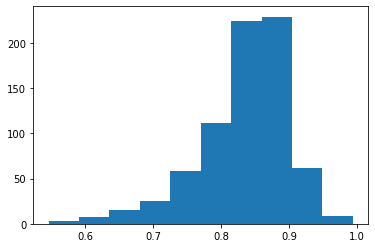

In [70]:
plt.hist(min_strat_est.propensity_scores)
plt.show()

In [20]:
print(min_strat_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                            
────────(Expectation(recurrence|age,antiplatelet,thickness_sum))
d[drain]                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,age,antiplatelet,thickness_sum,U) = P(recurrence|drain,age,antiplatelet,thickness_sum)

## Realized estimand
b: recurrence~drain+age+antiplatelet+thickness_sum
Target units: ate

## Estimate
Mean value: -0.09902833956511639
p-value: 0.002
95.0% confidence interval: (-0.16447411909065646, -0.033427197657667926)



In [21]:
print(data_strat_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|age,antiplatelet,stroke,platelet,thickness_sum
d[drain]                                                                      

                     
,ihd,inr,metalvalve))
                     
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,age,antiplatelet,stroke,platelet,thickness_sum,ihd,inr,metalvalve,U) = P(recurrence|drain,age,antiplatelet,stroke,platelet,thickness_sum,ihd,inr,metalvalve)

## Realized estimand
b: recurrence~drain+age+antiplatelet+stroke+platelet+thickness_sum+ihd+inr+metalvalve
Target units: ate

## Estimate
Mean value: -0.10000869239521332
p-value: 0.002
95.0% confidence interval: (-0.1656926504848836, -0.02954042917866058)



In [22]:
print(doc_strat_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|burrhole_num,bedrest,optype,age,antiplatelet,d
d[drain]                                                                      

                                                                        
ensity,stroke,hospital,thickness_sum,warfarin,ihd,metalvalve,membranes))
                                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,burrhole_num,bedrest,optype,age,antiplatelet,density,stroke,hospital,thickness_sum,warfarin,ihd,metalvalve,membranes,U) = P(recurrence|drain,burrhole_num,bedrest,optype,age,antiplatelet,density,stroke,hospital,thickness_sum,warfarin,ihd,metalvalve,membranes)

## Realized estimand
b: recurrence~drain+bur

In [71]:
dwh.print_estimate_comparison(naive_est, min_strat_est, 'Propensity score stratification')
dwh.print_estimate_comparison(naive_est, data_strat_est, 'Propensity score stratification')
dwh.print_estimate_comparison(naive_est_burr, doc_strat_est, 'Propensity score stratification')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Propensity score stratification causal estimate is -0.09902833956511639
Percentage change from naive_est: 5.843%
----------------------------------------------
-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Propensity score stratification causal estimate is -0.10000869239521332
Percentage change from naive_est: 6.891%
----------------------------------------------
-------------- Causal Estimates -------------- 
Naive causal estimate is -0.08374644024891888
Propensity score stratification causal estimate is -0.09744949171144184
Percentage change from naive_est: 16.363%
----------------------------------------------


---
## IV. Refute the obtained estimate


1. **Add Random Common Cause:** Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [72]:
min_ran_strat_refuter = min_model.refute_estimate(min_estimand, min_strat_est, 
                                                  num_simulations=10,
                                                  random_state=random_state,
                                                  method_name='random_common_cause')

In [73]:
data_ran_strat_refuter = data_model.refute_estimate(data_estimand, data_strat_est, 
                                                    num_simulations=10,
                                                    random_state=random_state,
                                                    method_name='random_common_cause')

In [74]:
doc_ran_strat_refuter = doc_model.refute_estimate(doc_estimand, doc_strat_est, 
                                                  num_simulations=10,
                                                  random_state=random_state,
                                                  method_name='random_common_cause')

In [75]:
print(min_ran_strat_refuter)
print(data_ran_strat_refuter)
print(doc_ran_strat_refuter)

Refute: Add a Random Common Cause
Estimated effect:-0.09902833956511639
New effect:-0.09614577640836014

Refute: Add a Random Common Cause
Estimated effect:-0.10000869239521332
New effect:-0.09873902933819229

Refute: Add a Random Common Cause
Estimated effect:-0.09744949171144184
New effect:-0.08580532214593938



2. **Placebo Treatment:** What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)



* Note that the placebo type is 'permute' meaning the rows of the treatment variable have been randomly permuted giving the effect of a placebo treatment.


In [76]:
# Robust if: estimate goes to 0
min_strat_placebo_refuter = min_model.refute_estimate(min_estimand, min_strat_est, 
                                                      method_name="placebo_treatment_refuter",
                                                      num_simulations=10,
                                                      placebo_type='permute')

In [77]:
data_strat_placebo_refuter = data_model.refute_estimate(data_estimand, data_strat_est, 
                                                        method_name="placebo_treatment_refuter",
                                                        num_simulations=10,
                                                        placebo_type='permute')

In [78]:
doc_strat_placebo_refuter = doc_model.refute_estimate(doc_estimand, doc_strat_est, 
                                                      method_name="placebo_treatment_refuter",
                                                      num_simulations=10,
                                                      placebo_type='permute')

In [79]:
print(min_strat_placebo_refuter)
print(data_strat_placebo_refuter)
print(doc_strat_placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:-0.09902833956511639
New effect:-0.013514562839332809
p value:0.26054479574094525

Refute: Use a Placebo Treatment
Estimated effect:-0.10000869239521332
New effect:-0.011289282681685584
p value:0.38428366932441826

Refute: Use a Placebo Treatment
Estimated effect:-0.09744949171144184
New effect:-0.00394064733592809
p value:0.4430574627069467



3. **Dummy Outcome:** What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)



* The result shows that when using a dummy outcome, the **treatment does not lead to the outcome**. The estimated effect is hence a value that tends to zero, which matches our expectation. This shows that if we replace the outcome by randomly generated data, the **estimator correctly predicts that the influence if treatment is zero**.


In [80]:
# Robust if: estimate goes to 0
min_strat_dummy_refuter = min_model.refute_estimate(min_estimand, min_strat_est, 
                                                    method_name="dummy_outcome_refuter",
                                                    random_state=random_state,
                                                    num_simulations=10)

In [81]:
data_strat_dummy_refuter = data_model.refute_estimate(data_estimand, data_strat_est, 
                                                      method_name="dummy_outcome_refuter",
                                                      random_state=random_state,
                                                      num_simulations=10)

In [82]:
doc_strat_dummy_refuter = doc_model.refute_estimate(doc_estimand, doc_strat_est, 
                                                    method_name="dummy_outcome_refuter",
                                                    random_state=random_state,
                                                    num_simulations=10)

In [83]:
print(min_strat_dummy_refuter[0])
print(data_strat_dummy_refuter[0])
print(doc_strat_dummy_refuter[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.009974746465265309
p value:0.43715706030964974

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.05379208742279593
p value:0.2947455960536751

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.008293318709714061
p value:0.47186702292277216



4. **Data Subsets Validation:** Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

In [84]:
min_strat_subset_refuter = min_model.refute_estimate(min_estimand, min_strat_est, 
                                                     method_name="data_subset_refuter",
                                                     subset_fraction=0.75,
                                                     random_state=random_state,
                                                     num_simulations=10)

In [85]:
data_strat_subset_refuter = data_model.refute_estimate(data_estimand, data_strat_est, 
                                                       method_name="data_subset_refuter",
                                                       subset_fraction=0.75,
                                                       random_state=random_state,
                                                       num_simulations=10)

In [86]:
doc_strat_subset_refuter = doc_model.refute_estimate(doc_estimand, doc_strat_est, 
                                                     method_name="data_subset_refuter",
                                                     subset_fraction=0.75,
                                                     random_state=random_state,
                                                     num_simulations=10)

In [87]:
print(min_strat_subset_refuter)
print(data_strat_subset_refuter)
print(doc_strat_subset_refuter)

Refute: Use a subset of data
Estimated effect:-0.09902833956511639
New effect:-0.07636487252577942
p value:0.0

Refute: Use a subset of data
Estimated effect:-0.10000869239521332
New effect:-0.08684877027090002
p value:0.0

Refute: Use a subset of data
Estimated effect:-0.09744949171144184
New effect:-0.07701483125761147
p value:0.0



5. **Bootstrap Validation:** Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

In [88]:
min_strat_bootstrap_refuter = min_model.refute_estimate(min_estimand, min_strat_est, 
                                                        method_name="bootstrap_refuter",
                                                        random_state=random_state,
                                                        num_simulations=10)

In [89]:
data_strat_bootstrap_refuter = data_model.refute_estimate(data_estimand, data_strat_est, 
                                                          method_name="bootstrap_refuter",
                                                          random_state=random_state,
                                                          num_simulations=10)

In [90]:
doc_strat_bootstrap_refuter = doc_model.refute_estimate(doc_estimand, doc_strat_est, 
                                                        method_name="bootstrap_refuter",
                                                        random_state=random_state,
                                                        num_simulations=10)

In [91]:
print(min_strat_bootstrap_refuter)
print(data_strat_bootstrap_refuter)
print(doc_strat_bootstrap_refuter)

Refute: Bootstrap Sample Dataset
Estimated effect:-0.09902833956511639
New effect:-0.147745504676513
p value:0.0

Refute: Bootstrap Sample Dataset
Estimated effect:-0.10000869239521332
New effect:-0.18829372275871512
p value:0.0003352327372134756

Refute: Bootstrap Sample Dataset
Estimated effect:-0.09744949171144184
New effect:-0.1348202154285648
p value:0.09080344283805986

